In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open("ibmapi.txt", "r") as f:
    token = f.read().strip()

QiskitRuntimeService.save_account(
    token=token,
    instance="Practice",
    set_as_default=True,
    overwrite=True  # Allow overwriting the existing account
)

service = QiskitRuntimeService()

In [3]:
provider = service.backends()

In [4]:
provider

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]

In [5]:
for backend in provider:
    name = backend.name
    qubits = backend.num_qubits
    status = backend.status().operational
    pending_jobs = backend.status().pending_jobs
    print(f"Backend: {name}, Qubits: {qubits}, Operational: {status}, Pending Jobs: {pending_jobs}")

Backend: ibm_torino, Qubits: 133, Operational: True, Pending Jobs: 427
Backend: ibm_brisbane, Qubits: 127, Operational: True, Pending Jobs: 2058


In [6]:
from qiskit.visualization import plot_histogram

In [7]:
simulator = service.backend("ibm_torino")

In [10]:
NUM_BITS = 2
a_val = 1 # Decimal 1, binary 01
b_val = 2 # Decimal 2, binary 10
print(f"--- 2-bit Reversible Adder: Encoding Inputs ---")
print(f"Adding: {a_val} (binary: {bin(a_val)[2:].zfill(NUM_BITS)}) + {b_val} (binary: {bin(b_val)[2:].zfill(NUM_BITS)})")
total_qubits_2bit_new = 2 * NUM_BITS + NUM_BITS + NUM_BITS + 1 # Inputs (4) + Sum (2) + Carries (2) + Ancilla (1) = 9 qubits
a_reg_2bit = QuantumRegister(NUM_BITS, 'a')
b_reg_2bit = QuantumRegister(NUM_BITS, 'b')
sum_reg_2bit = QuantumRegister(NUM_BITS, 'sum')
carry_reg_2bit = QuantumRegister(NUM_BITS, 'carry') # carry_reg[0] will be C_out[0], carry_reg[1] will be C_out[1]
# A dedicated ancilla qubit for the A XOR B term in the Carry-out formula
ancilla_fa_2bit = QuantumRegister(1, 'ancilla_fa') # Ancilla for full adder carry logi
# Classical registers for measurement (matching new quantum registers)
a_classical_2bit = ClassicalRegister(NUM_BITS, 'a_meas')
b_classical_2bit = ClassicalRegister(NUM_BITS, 'b_meas')
sum_classical_2bit = ClassicalRegister(NUM_BITS, 'sum_meas')
carry_classical_2bit = ClassicalRegister(NUM_BITS, 'carry_meas') # Now measures 2 carry bits
ancilla_fa_classical_2bit = ClassicalRegister(1, 'ancilla_meas') # Measures ancilla
# Create the main quantum circuit
qc_adder_2bit = QuantumCircuit(
    a_reg_2bit, b_reg_2bit, sum_reg_2bit, carry_reg_2bit, ancilla_fa_2bit, # All quantum registers
    a_classical_2bit, b_classical_2bit, sum_classical_2bit, carry_classical_2bit, ancilla_fa_classical_2bit # All classical registers
)
for i in range(NUM_BITS):
    if (a_val >> i) & 1:
        qc_adder_2bit.x(a_reg_2bit[i])
print(f"Encoded A: {bin(a_val)[2:].zfill(NUM_BITS)}")

for i in range(NUM_BITS):
    if (b_val >> i) & 1:
        qc_adder_2bit.x(b_reg_2bit[i])
print(f"Encoded B: {bin(b_val)[2:].zfill(NUM_BITS)}")
qc_adder_2bit.barrier(label='Inputs Encoded')
qc_adder_2bit.cx(a_reg_2bit[0], sum_reg_2bit[0])
qc_adder_2bit.cx(b_reg_2bit[0], sum_reg_2bit[0])
qc_adder_2bit.ccx(a_reg_2bit[0], b_reg_2bit[0], carry_reg_2bit[0])
qc_adder_2bit.barrier(label='LSB Added')
qc_adder_2bit.cx(a_reg_2bit[1], sum_reg_2bit[1])
qc_adder_2bit.cx(b_reg_2bit[1], sum_reg_2bit[1])
qc_adder_2bit.cx(carry_reg_2bit[0], sum_reg_2bit[1]) # XOR with Carry_in (Carry[0])
qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])
qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])
qc_adder_2bit.ccx(carry_reg_2bit[0], ancilla_fa_2bit[0], carry_reg_2bit[1])
qc_adder_2bit.ccx(a_reg_2bit[1], b_reg_2bit[1], carry_reg_2bit[1])
# UNCOMPUTE the ancilla_fa_2bit[0] qubit! It's no longer needed and must be returned to |0⟩.
qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])
qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])
qc_adder_2bit.barrier(label='MSB Added')
qc_adder_2bit.barrier(label='Addition Complete')



--- 2-bit Reversible Adder: Encoding Inputs ---
Adding: 1 (binary: 01) + 2 (binary: 10)
Encoded A: 01
Encoded B: 10


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "a"), index=0>, <Qubit register=(2, "a"), index=1>, <Qubit register=(2, "b"), index=0>, <Qubit register=(2, "b"), index=1>, <Qubit register=(2, "sum"), index=0>, <Qubit register=(2, "sum"), index=1>, <Qubit register=(2, "carry"), index=0>, <Qubit register=(2, "carry"), index=1>, <Qubit register=(1, "ancilla_fa"), index=0>), clbits=())

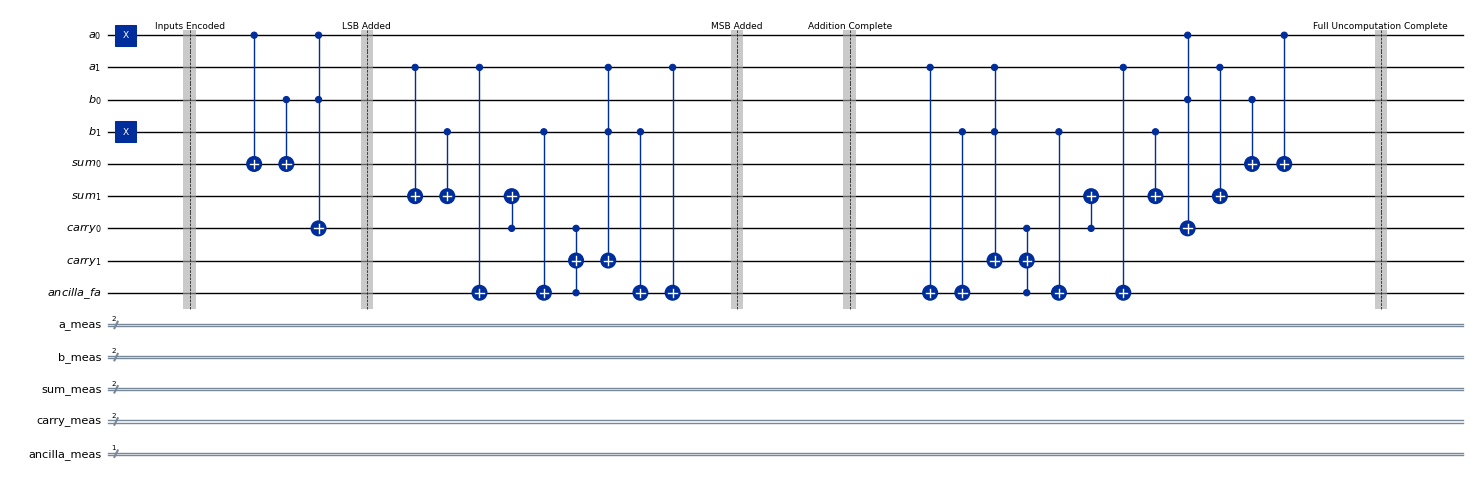

In [11]:
# --- Reverse Computation (Uncomputation) ---
# This section reverses every gate from the forward pass in *exact reverse order*.
# Since CNOT (cx) and Toffoli (ccx) gates are their own inverses, we simply re-apply them.

# Reversing from the very last gates of the forward pass, moving backward:

# 12. Reverse: UNCOMPUTE the ancilla_fa_2bit[0] qubit (last gate of forward pass)
#     This was: qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])
#     Applying it again *re-computes* (A[1] XOR B[1]) into the ancilla.
#     This state is needed for the next step: reversing Carry[1] part 1.
qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])

# 11. Reverse: UNCOMPUTE the ancilla_fa_2bit[0] qubit (second-to-last gate of forward pass)
#     This was: qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])
#     Applying it again *re-computes* (A[1] XOR B[1]) into the ancilla.
qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])

# 10. Reverse: Compute (A[1] AND B[1]) into carry_reg_2bit[1] (third-to-last gate of forward pass)
#     This was: qc_adder_2bit.ccx(a_reg_2bit[1], b_reg_2bit[1], carry_reg_2bit[1])
qc_adder_2bit.ccx(a_reg_2bit[1], b_reg_2bit[1], carry_reg_2bit[1])

# 9. Reverse: Compute (Carry[0] AND (A[1] ⊕ B[1])) into carry_reg_2bit[1] (fourth-to-last gate of forward pass)
#     This was: qc_adder_2bit.ccx(carry_reg_2bit[0], ancilla_fa_2bit[0], carry_reg_2bit[1])
qc_adder_2bit.ccx(carry_reg_2bit[0], ancilla_fa_2bit[0], carry_reg_2bit[1])

# 8. Reverse: Compute A[1] ⊕ B[1] into ancilla_fa_2bit[0] (part 2)
#     This was: qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])
#     Applying it again *clears* the ancilla back to |0⟩.
qc_adder_2bit.cx(b_reg_2bit[1], ancilla_fa_2bit[0])

# 7. Reverse: Compute A[1] ⊕ B[1] into ancilla_fa_2bit[0] (part 1)
#     This was: qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])
#     Applying it again *clears* the ancilla back to |0⟩.
qc_adder_2bit.cx(a_reg_2bit[1], ancilla_fa_2bit[0])

# 6. Reverse: MSB Sum (XOR with Carry[0])
#     This was: qc_adder_2bit.cx(carry_reg_2bit[0], sum_reg_2bit[1])
qc_adder_2bit.cx(carry_reg_2bit[0], sum_reg_2bit[1])

# 5. Reverse: MSB Sum (XOR with B[1])
#     This was: qc_adder_2bit.cx(b_reg_2bit[1], sum_reg_2bit[1])
qc_adder_2bit.cx(b_reg_2bit[1], sum_reg_2bit[1])

# 4. Reverse: MSB Sum (XOR with A[1])
#     This was: qc_adder_2bit.cx(a_reg_2bit[1], sum_reg_2bit[1])
qc_adder_2bit.cx(a_reg_2bit[1], sum_reg_2bit[1])

# 3. Reverse: LSB Carry (A[0] AND B[0])
#     This was: qc_adder_2bit.ccx(a_reg_2bit[0], b_reg_2bit[0], carry_reg_2bit[0])
qc_adder_2bit.ccx(a_reg_2bit[0], b_reg_2bit[0], carry_reg_2bit[0])

# 2. Reverse: LSB Sum (XOR with B[0])
#     This was: qc_adder_2bit.cx(b_reg_2bit[0], sum_reg_2bit[0])
qc_adder_2bit.cx(b_reg_2bit[0], sum_reg_2bit[0])

# 1. Reverse: LSB Sum (XOR with A[0])
#     This was: qc_adder_2bit.cx(a_reg_2bit[0], sum_reg_2bit[0])
qc_adder_2bit.cx(a_reg_2bit[0], sum_reg_2bit[0])

# Optional barrier to separate the uncomputation visually
qc_adder_2bit.barrier(label='Full Uncomputation Complete')
qc_adder_2bit.draw(output='mpl', scale=0.5, fold=-1)

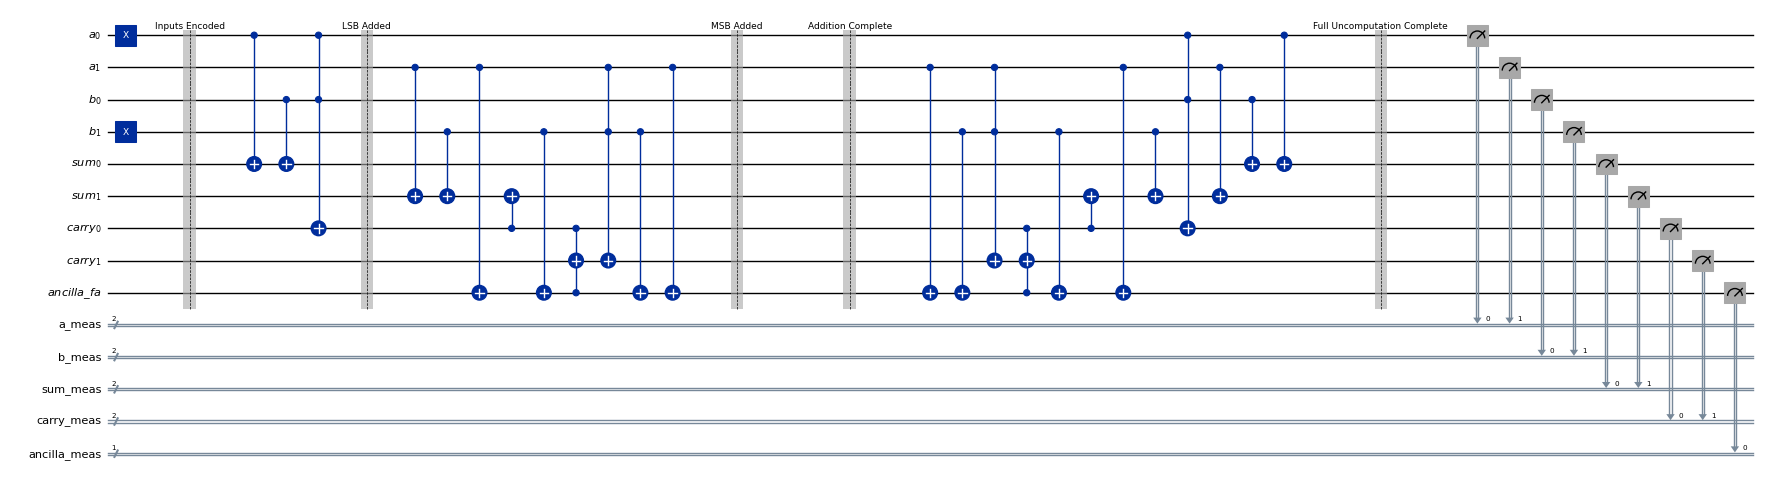

In [12]:
qc_adder_2bit.measure(a_reg_2bit, a_classical_2bit)
qc_adder_2bit.measure(b_reg_2bit, b_classical_2bit)
qc_adder_2bit.measure(sum_reg_2bit, sum_classical_2bit)
qc_adder_2bit.measure(carry_reg_2bit, carry_classical_2bit) # Now measures 2 classical bits
qc_adder_2bit.measure(ancilla_fa_2bit, ancilla_fa_classical_2bit) # Measures ancilla
qc_adder_2bit.draw(output='mpl', scale=0.5, fold=-1)

In [13]:
# --- Analyzing the Uncomputation Result (MODIFIED) ---
print(f"\n--- 2-bit Reversible Adder: Analyzing Uncomputation Results (Explicit C_out) ---")
print(f"Original Input A: {a_val} (binary: {bin(a_val)[2:].zfill(NUM_BITS)})")
print(f"Original Input B: {b_val} (binary: {bin(b_val)[2:].zfill(NUM_BITS)})")



--- 2-bit Reversible Adder: Analyzing Uncomputation Results (Explicit C_out) ---
Original Input A: 1 (binary: 01)
Original Input B: 2 (binary: 10)


In [14]:
# Simulate the uncomputation circuit
from qiskit_ibm_runtime import Sampler
import time
from qiskit import transpile

transpiled_qc_rev = transpile(qc_adder_2bit, simulator)

sampler = Sampler(simulator)

job = sampler.run([transpiled_qc_rev], shots=1024)
while not job.done():
    print(f"Job is still running. Current status: {job.status()}")
    time.sleep(2)

job.wait_for_final_state()
print(f"Job completed with status: {job.status()}")
result = job.result()



Job is still running. Current status: QUEUED
Job is still running. Current status: RUNNING
Job is still running. Current status: RUNNING
Job completed with status: DONE


In [16]:
data = result[0].data

a_meas_bits = data.a_meas
b_meas_bits = data.b_meas
sum_meas_bits = data.sum_meas
carry_meas_bits = data.carry_meas
ancilla_meas_bits = data.ancilla_meas

In [17]:
# --- Analyzing the Uncomputation Result (MODIFIED) ---
print(f"\n--- 2-bit Reversible Adder: Analyzing Uncomputation Results (Explicit C_out) ---")
print(f"Original Input A: {a_val} (binary: {bin(a_val)[2:].zfill(NUM_BITS)})")
print(f"Original Input B: {b_val} (binary: {bin(b_val)[2:].zfill(NUM_BITS)})")

# Get counts from the individual classical registers
a_counts = a_meas_bits.get_counts()
b_counts = b_meas_bits.get_counts()
sum_counts = sum_meas_bits.get_counts()
carry_counts = carry_meas_bits.get_counts()
ancilla_counts = ancilla_meas_bits.get_counts()

# Find the most frequent outcome for each register
most_frequent_a_rev = max(a_counts.keys(), key=a_counts.get)
most_frequent_b_rev = max(b_counts.keys(), key=b_counts.get)
most_frequent_sum_rev = max(sum_counts.keys(), key=sum_counts.get)
most_frequent_carry_rev = max(carry_counts.keys(), key=carry_counts.get)
most_frequent_ancilla_rev = max(ancilla_counts.keys(), key=ancilla_counts.get)

# Convert to integers
measured_a_rev = int(most_frequent_a_rev, 2)
measured_b_rev = int(most_frequent_b_rev, 2)
measured_sum_rev = int(most_frequent_sum_rev, 2) # Should be 0
measured_carry_rev = int(most_frequent_carry_rev, 2) # Should be 0 (C1C0 cleared)
measured_ancilla_rev = int(most_frequent_ancilla_rev, 2) # Should be 0

print(f"\nMost Frequent Outcome after Uncomputation:")
print(f"  A register: '{most_frequent_a_rev}'")
print(f"  B register: '{most_frequent_b_rev}'")
print(f"  Sum register: '{most_frequent_sum_rev}'")
print(f"  Carry register: '{most_frequent_carry_rev}'")
print(f"  Ancilla register: '{most_frequent_ancilla_rev}'")

print(f"  Measured A (recovered): {measured_a_rev} (Binary: {most_frequent_a_rev})")
print(f"  Measured B (recovered): {measured_b_rev} (Binary: {most_frequent_b_rev})")
print(f"  Measured Sum_reg (cleared): {measured_sum_rev} (Binary: {most_frequent_sum_rev})")
print(f"  Measured Carry_reg (cleared): {measured_carry_rev} (Binary: {most_frequent_carry_rev})")
print(f"  Measured Ancilla_FA (cleared): {measured_ancilla_rev}")

# Final Verification
print(f"\nFinal Reversibility Verification:")
print(f"  Inputs A Recovered: {measured_a_rev == a_val} {'✅' if measured_a_rev == a_val else '❌'}")
print(f"  Inputs B Recovered: {measured_b_rev == b_val} {'✅' if measured_b_rev == b_val else '❌'}")
print(f"  Sum Register Cleared: {measured_sum_rev == 0} {'✅' if measured_sum_rev == 0 else '❌'}")
print(f"  Carry Registers Cleared: {measured_carry_rev == 0} {'✅' if measured_carry_rev == 0 else '❌'}")
print(f"  Ancilla Cleared: {measured_ancilla_rev == 0} {'✅' if measured_ancilla_rev == 0 else '❌'}")

if (measured_a_rev == a_val and measured_b_rev == b_val and
    measured_sum_rev == 0 and measured_carry_rev == 0 and
    measured_ancilla_rev == 0):
    print("\n🎉 Congratulations! The reversible 2-bit binary adder with explicit carry-out successfully demonstrated full reversibility!")
else:
    print("\n❌ Reversibility demonstration failed. Check circuit logic and uncomputation steps.")


--- 2-bit Reversible Adder: Analyzing Uncomputation Results (Explicit C_out) ---
Original Input A: 1 (binary: 01)
Original Input B: 2 (binary: 10)

Most Frequent Outcome after Uncomputation:
  A register: '01'
  B register: '10'
  Sum register: '00'
  Carry register: '00'
  Ancilla register: '0'
  Measured A (recovered): 1 (Binary: 01)
  Measured B (recovered): 2 (Binary: 10)
  Measured Sum_reg (cleared): 0 (Binary: 00)
  Measured Carry_reg (cleared): 0 (Binary: 00)
  Measured Ancilla_FA (cleared): 0

Final Reversibility Verification:
  Inputs A Recovered: True ✅
  Inputs B Recovered: True ✅
  Sum Register Cleared: True ✅
  Carry Registers Cleared: True ✅
  Ancilla Cleared: True ✅

🎉 Congratulations! The reversible 2-bit binary adder with explicit carry-out successfully demonstrated full reversibility!


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import circuit_drawer

def create_reversible_adder(num_bits, a_val, b_val):
    """
    Creates a reversible quantum adder circuit for two n-bit numbers.

    This function builds the circuit using a half-adder for the least
    significant bit (LSB) and a series of full-adders for the remaining bits,
    which is a standard approach for ripple-carry adders. The ancilla qubit
    is uncomputed after each full-adder stage to return it to the |0> state,
    ensuring the overall circuit is reversible.

    Args:
        num_bits (int): The number of bits for the adder.
        a_val (int): The first decimal value to add.
        b_val (int): The second decimal value to add.

    Returns:
        QuantumCircuit: The constructed quantum adder circuit.
    """
    # Print header for clarity
    print(f"--- {num_bits}-bit Reversible Adder: Encoding Inputs ---")
    print(f"Adding: {a_val} (binary: {bin(a_val)[2:].zfill(num_bits)}) + {b_val} (binary: {bin(b_val)[2:].zfill(num_bits)})")
    
    # Define quantum and classical registers
    a_reg = QuantumRegister(num_bits, 'a')
    b_reg = QuantumRegister(num_bits, 'b')
    sum_reg = QuantumRegister(num_bits, 'sum')
    carry_reg = QuantumRegister(num_bits, 'carry')
    # A single ancilla qubit is sufficient for the entire circuit
    ancilla_fa = QuantumRegister(1, 'ancilla_fa')

    # Create classical registers for measurement
    a_classical = ClassicalRegister(num_bits, 'a_meas')
    b_classical = ClassicalRegister(num_bits, 'b_meas')
    sum_classical = ClassicalRegister(num_bits, 'sum_meas')
    carry_classical = ClassicalRegister(num_bits, 'carry_meas')
    ancilla_fa_classical = ClassicalRegister(1, 'ancilla_meas')
    
    # Create the main quantum circuit
    qc = QuantumCircuit(
        a_reg, b_reg, sum_reg, carry_reg, ancilla_fa,
        a_classical, b_classical, sum_classical, carry_classical, ancilla_fa_classical
    )
    
    # Encode the decimal inputs into the quantum registers
    for i in range(num_bits):
        if (a_val >> i) & 1:
            qc.x(a_reg[i])
    print(f"Encoded A: {bin(a_val)[2:].zfill(num_bits)}")

    for i in range(num_bits):
        if (b_val >> i) & 1:
            qc.x(b_reg[i])
    print(f"Encoded B: {bin(b_val)[2:].zfill(num_bits)}")
    qc.barrier(label='Inputs Encoded')

    # Apply a Half-Adder for the LSB (bit 0)
    # Sum_0 = A_0 XOR B_0
    qc.cx(a_reg[0], sum_reg[0])
    qc.cx(b_reg[0], sum_reg[0])
    # Carry_out_0 = A_0 AND B_0
    qc.ccx(a_reg[0], b_reg[0], carry_reg[0])
    qc.barrier(label='LSB Added')

    # Loop for subsequent bits (Full-Adder logic)
    for i in range(1, num_bits):
        # Sum_i = A_i XOR B_i XOR Carry_in_{i-1}
        qc.cx(a_reg[i], sum_reg[i])
        qc.cx(b_reg[i], sum_reg[i])
        qc.cx(carry_reg[i-1], sum_reg[i]) 
        
        # Calculate Carry_out_i = (A_i XOR B_i) AND Carry_in_{i-1} OR (A_i AND B_i)
        # Use ancilla to temporary store A_i XOR B_i
        qc.cx(a_reg[i], ancilla_fa[0])
        qc.cx(b_reg[i], ancilla_fa[0])
        
        # Part 1 of carry-out: (A_i XOR B_i) AND Carry_in_{i-1}
        qc.ccx(carry_reg[i-1], ancilla_fa[0], carry_reg[i])
        # Part 2 of carry-out: A_i AND B_i
        qc.ccx(a_reg[i], b_reg[i], carry_reg[i])
        
        # Uncompute ancilla_fa[0] to return it to |0> for the next iteration
        qc.cx(b_reg[i], ancilla_fa[0])
        qc.cx(a_reg[i], ancilla_fa[0])
        
    qc.barrier(label='Addition Complete')

    # Measurement of all registers for verification
    qc.measure(a_reg, a_classical)
    qc.measure(b_reg, b_classical)
    qc.measure(sum_reg, sum_classical)
    qc.measure(carry_reg, carry_classical)
    qc.measure(ancilla_fa, ancilla_fa_classical)
    
    return qc

def simulate_and_analyze(qc, num_bits, a_val, b_val):
    """
    Simulates the quantum circuit and analyzes the results.

    Args:
        qc (QuantumCircuit): The circuit to simulate.
        num_bits (int): The number of bits used for the adder.
        a_val (int): The first decimal value.
        b_val (int): The second decimal value.
    """
    print(f"\n--- {num_bits}-bit Reversible Adder: Simulating Results ---")

    # Calculate expected sum for verification
    expected_sum_decimal = a_val + b_val
    expected_sum_binary_full = bin(expected_sum_decimal)[2:].zfill(num_bits + 1)
    print(f"Expected Sum (Decimal): {expected_sum_decimal}")
    print(f"Expected Sum (Binary, {num_bits+1} bits): {expected_sum_binary_full}")

    # Set up the simulator
    simulator = Aer.get_backend('aer_simulator')

    # Transpile the circuit for the simulator
    transpiled_qc_adder = transpile(qc, simulator)

    # Run the simulation
    job_adder = simulator.run(transpiled_qc_adder, shots=1024)
    result_adder = job_adder.result()
    counts_adder = result_adder.get_counts()

    # Find the most frequent outcome
    # For NUM_BITS=2, this is 'A0 C1C0 S1S0 B1B0 A1A0' (A0=ancilla, C1C0=carry_reg, S1S0=sum_reg, etc.)
    most_frequent_adder = max(counts_adder.keys(), key=counts_adder.get)
    print(f"\nMost Frequent Outcome: {most_frequent_adder}")

    # Decode the measured bitstring
    # The order of the classical registers in the bitstring is reversed from creation
    # The string format is 'ancilla_fa_meas carry_meas sum_meas b_meas a_meas'
    bits_split = most_frequent_adder.split(' ')

    # The number of classical registers is fixed at 5 for this circuit.
    if len(bits_split) != 5:
        print("Error: The number of measured classical registers is not as expected (5).")
        return

    measured_ancilla_fa_str = bits_split[0]
    measured_carry_str = bits_split[1]   
    measured_sum_str = bits_split[2]     
    measured_b_str = bits_split[3]
    measured_a_str = bits_split[4]

    # Convert binary strings to integers
    measured_a = int(measured_a_str, 2)
    measured_b = int(measured_b_str, 2)
    measured_sum_lower = int(measured_sum_str, 2)
    
    # The final carry-out is the MSB of the carry register
    final_carry_bit_str = measured_carry_str[0] if measured_carry_str else '0'
    final_carry_bit = int(final_carry_bit_str, 2)

    # The total sum is the combination of the final carry and the sum register
    total_measured_sum = (final_carry_bit << num_bits) + measured_sum_lower

    # Print decoded values
    print(f"  Decoded Measured A: {measured_a} (Binary: {measured_a_str})")
    print(f"  Decoded Measured B: {measured_b} (Binary: {measured_b_str})")
    print(f"  Decoded Measured Sum_reg: {measured_sum_lower} (Binary: {measured_sum_str})")
    print(f"  Decoded Measured Ancilla_FA: {int(measured_ancilla_fa_str, 2)}")
    print(f"  Total Measured Sum (Decimal): {total_measured_sum}")
    print(f"  Total Measured Sum (Binary, {num_bits+1} bits): {bin(total_measured_sum)[2:].zfill(num_bits + 1)}")

    # Verification
    print(f"\nVerification:")
    print(f"  Inputs Preserved (A): {measured_a == a_val} {'✅' if measured_a == a_val else '❌'}")
    print(f"  Inputs Preserved (B): {measured_b == b_val} {'✅' if measured_b == b_val else '❌'}")
    print(f"  Addition Result Correct: {total_measured_sum == expected_sum_decimal} {'✅' if total_measured_sum == expected_sum_decimal else '❌'}")
    print(f"  Ancilla Cleared: {int(measured_ancilla_fa_str, 2) == 0} {'✅' if int(measured_ancilla_fa_str, 2) == 0 else '❌'}")
    
def main():
    """Main function to run the quantum adder simulation."""
    try:
        # --- Configure your inputs here via user input ---
        num_bits = int(input("Enter the number of bits for the adder (e.g., 5): "))
        a_val = int(input(f"Enter the first decimal value (0 to {2**num_bits - 1}): "))
        b_val = int(input(f"Enter the second decimal value (0 to {2**num_bits - 1}): "))

        if a_val < 0 or b_val < 0 or a_val >= 2**num_bits or b_val >= 2**num_bits:
            print(f"Error: Input values must be between 0 and {2**num_bits - 1} for a {num_bits}-bit adder.")
            return

        # Create the quantum circuit
        qc_adder = create_reversible_adder(num_bits, a_val, b_val)
        
        print("\n--- Visualizing the Circuit (Requires matplotlib) ---")
        qc_adder.draw(output='mpl', fold=-1, filename='reversible_adder_circuit.png')
        print("Circuit diagram saved to 'reversible_adder_circuit.png'")
        # Note: To view the image, you need a local environment that can render matplotlib.
        
        # Simulate and analyze the results
        simulate_and_analyze(qc_adder, num_bits, a_val, b_val)
    except ValueError:
        print("Invalid input. Please enter valid integers.")

if __name__ == "__main__":
    main()


--- 3-bit Reversible Adder: Encoding Inputs ---
Adding: 3 (binary: 011) + 7 (binary: 111)
Encoded A: 011
Encoded B: 111

--- Visualizing the Circuit (Requires matplotlib) ---
Circuit diagram saved to 'reversible_adder_circuit.png'

--- 3-bit Reversible Adder: Simulating Results ---
Expected Sum (Decimal): 10
Expected Sum (Binary, 4 bits): 1010

Most Frequent Outcome: 0 111 010 111 011
  Decoded Measured A: 3 (Binary: 011)
  Decoded Measured B: 7 (Binary: 111)
  Decoded Measured Sum_reg: 2 (Binary: 010)
  Decoded Measured Ancilla_FA: 0
  Total Measured Sum (Decimal): 10
  Total Measured Sum (Binary, 4 bits): 1010

Verification:
  Inputs Preserved (A): True ✅
  Inputs Preserved (B): True ✅
  Addition Result Correct: True ✅
  Ancilla Cleared: True ✅
